# Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import uniform, randn
import nengo

# Parametrisierung der Lernrate

In [3]:
def parametrize_learning_law(v0, vf, t0, tf, learning_type):
    assert learning_type in ('sigmoid', 'invtime', 'exp')

    #Matrix zur Speicherung der parametrisierten Lernrate für jeden Schritt
    y = np.zeros((tf - t0,))

    #Zeitschritte von 1 bis tf
    t = np.array([i for i in range(1, tf +1 )])

    #Unterscheidung nach Lernarten (sigmoid, invtime, exp)
    if learning_type == 'sigmoid':
        s = -np.floor(np.log10(tf)) * 10**(-(np.floor(np.log10(tf))))
        p = abs(s*10**(np.floor(np.log10(tf)) + np.floor(np.log10(tf))/2))
        y = v0 - (v0)/(1+np.exp(s*(t-(tf/p)))) + vf
    
    elif learning_type == 'invtime':
        B = (vf * tf - v0 * t0) / (v0 - vf)
        A = v0 * t0 + B * v0
        y = [A / (t[i] + B) for i in range(len(t))]
    
    elif learning_type == 'exp':
        if v0 < 1:
            p = -np.log(v0)
        else:
            p = np.log(v0)
        y = v0 * np.exp(-t/(tf/p))

    return y

# Parameter

In [4]:
#Anzahl Ensembles
N_ENS = 2

#Anzahl der Neuronen in SOM
N_NEURONS = 50

#Wertebereich
RADIUS = 1.

#Schrittweite der Nengo-Simulation
DT = .001

#Max Anzahl Epochen für inneres Lernen der SOM
MAX_EPOCHS_IN_LEARNING = 50

#Max Anzahl Epochen für äußeres Lernen der SOM
MAX_EPOCHS_XMOD_LEARNING = 100

#Anzahl Samples für Training
N_SAMPLES = 1500

#Aktivitätsverfallrate
ETA = 1.

#Gewichtsverfallrate
XI = 1e-3

#Lernarten
LEARNING_TYPES = ['sigmoid', 'invtime', 'exp']

#Parametrisierung der Lernraten
sigma0 = N_NEURONS / 2. #ursprünglicher Wert
sigmaf = 1.             #finaler Wert
SIGMAT = parametrize_learning_law(v0=sigma0, vf=sigmaf, t0=1, tf=MAX_EPOCHS_IN_LEARNING, learning_type='invtime')
alpha0 = .1             #ursprünglicher Wert
alphaf = .001           #finaler Wert
ALPHAT = parametrize_learning_law(v0=alpha0, vf=alphaf, t0=1, tf=MAX_EPOCHS_IN_LEARNING, learning_type='exp')

#Vorhandene Sensoren
SENSORES = ['x', 'y']
assert len(SENSORES) == N_ENS

ACTIVITY = {}
for i in range(N_ENS):
    ACTIVITY[i] = np.zeros((N_NEURONS))

# Matrizen für Inputgewichte zwischen den Neuronen werden abgespeichert, um als transform-Parameter auf Ensembles angewandt werden zu können
INPUT_WEIGHTS = {}
for i, _ in enumerate(SENSORES):
    INPUT_WEIGHTS[i] = np.zeros((N_NEURONS,))

# Standartabweichungen zur Berechnungen der Gewichtsänderungen
SIGMA_DEF =.045
STD = {}
for i, _ in enumerate(SENSORES):
    STD[i] = SIGMA_DEF * np.ones((N_NEURONS,))

# Matrizen für X-Korrelation zwischen den Neuronen werden abgespeichert, um als transform-Parameter auf Ensembles angewandt werden zu können
W_CROSS = uniform(0, 1, (N_NEURONS, N_NEURONS))
XMOD_WEIGHTS = {}
for i, _ in enumerate(SENSORES):
    XMOD_WEIGHTS[i] = W_CROSS / W_CROSS.sum()

In [14]:
#setzt Parameter zurück zur Wiederverwendung
def reset_matrices():
    for i, _ in enumerate(SENSORES):
        ACTIVITY[i] = np.zeros((N_NEURONS,))
        INPUT_WEIGHTS[i] = np.zeros((N_NEURONS,))
        STD[i] = SIGMA_DEF * np.ones((N_NEURONS,))
        XMOD_WEIGHTS[i] = W_CROSS / W_CROSS.sum()

In [ ]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(ALPHAT, linewidth=3)
plt.xlabel('Epochen')
plt.ylabel('Hebbian Learning rate')

plt.subplot(2, 1, 2)
plt.plot(SIGMAT, linewidth=3)
plt.xlabel('Epochen')
plt.ylabel('SOM neighborhood size')

# Sensordaten

In [5]:
def generate_test_data():
    data = {}

    x_std = .25
    data['x'] = np.array(np.random.uniform(-1,1, N_SAMPLES))
    
    y_std = .025
    data['y'] = np.array([x**3 + randn() * y_std for _,x in enumerate(data['x'])])

    return data

In [6]:
data = generate_test_data()
sensory_data = np.column_stack((data['x'], data['y']))

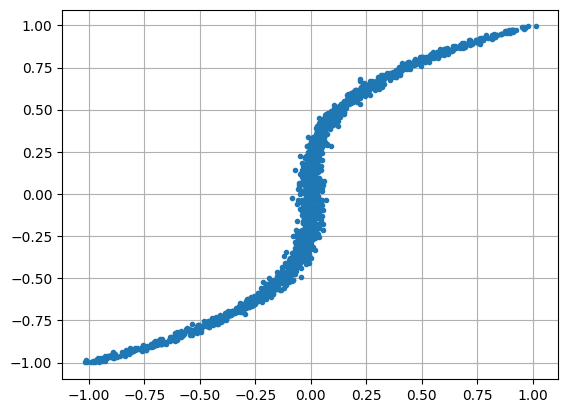

In [7]:
plt.plot(data['y'], data['x'], '.')
plt.grid()
plt.show()

(array([  7.,  12.,  12.,   8.,   7.,  12.,  13.,   9.,  18.,  11.,  19.,
         15.,  24.,  15.,  17.,  19.,  16.,  21.,  25.,  28.,  39.,  33.,
         52.,  83., 211., 254., 113.,  46.,  38.,  28.,  27.,  28.,  26.,
         13.,  20.,  20.,  11.,  24.,  14.,  17.,  13.,  10.,  15.,   9.,
         10.,  10.,   9.,  12.,   5.,   2.]),
 array([-1.01923062, -0.9785784 , -0.93792618, -0.89727395, -0.85662173,
        -0.81596951, -0.77531728, -0.73466506, -0.69401283, -0.65336061,
        -0.61270839, -0.57205616, -0.53140394, -0.49075172, -0.45009949,
        -0.40944727, -0.36879505, -0.32814282, -0.2874906 , -0.24683838,
        -0.20618615, -0.16553393, -0.12488171, -0.08422948, -0.04357726,
        -0.00292504,  0.03772719,  0.07837941,  0.11903163,  0.15968386,
         0.20033608,  0.2409883 ,  0.28164053,  0.32229275,  0.36294498,
         0.4035972 ,  0.44424942,  0.48490165,  0.52555387,  0.56620609,
         0.60685832,  0.64751054,  0.68816276,  0.72881499,  0.76946721,
 

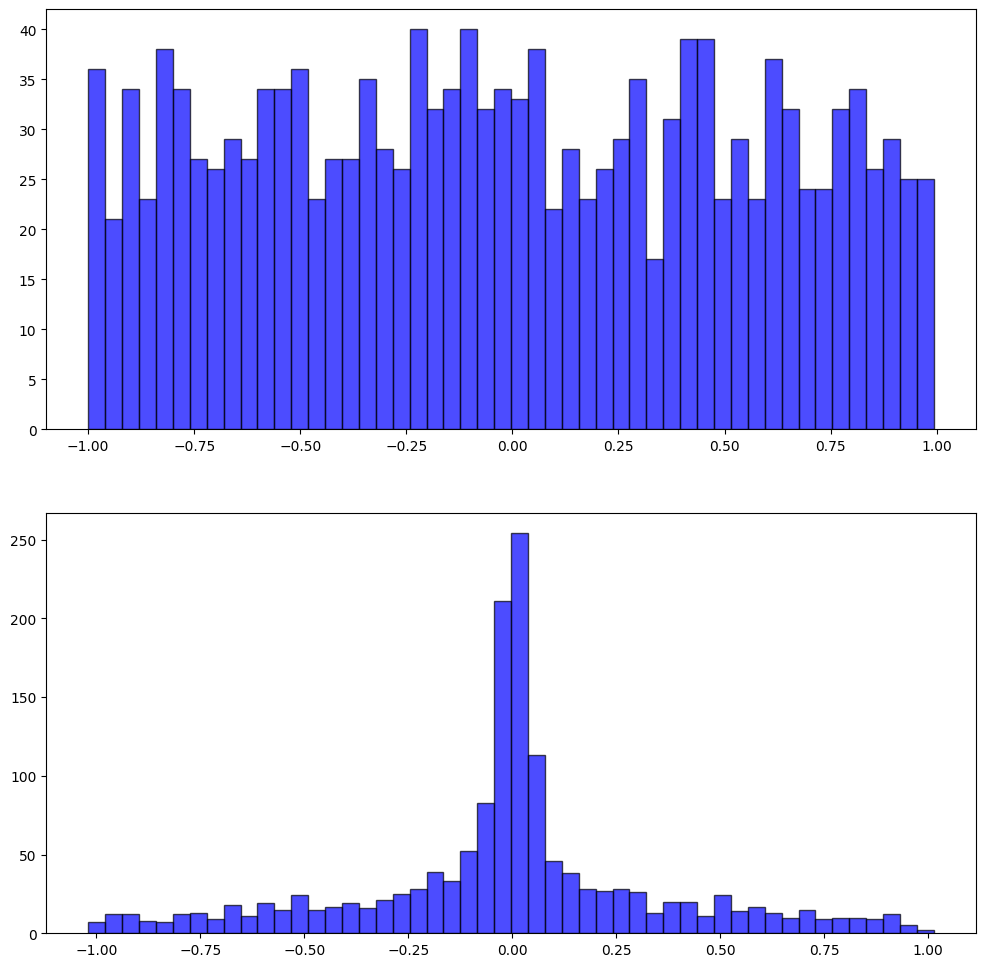

In [8]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.hist(data['x'],bins=50,facecolor="blue", edgecolor="black", alpha=0.7)

plt.subplot(2, 1, 2)
plt.hist(data['y'],bins=50,facecolor="blue", edgecolor="black", alpha=0.7)

# Lernalgorithmen

## Update-Activity

In [88]:
#für Ansatz, welcher nur den activity-Vektor als Ensemble implementiert
def update_activity_vector(sensor, activity, datapoint):
    #Initialisierung des Aktivitätsvektors auf 0
    act_cur = np.zeros((N_NEURONS,))

    #Berechnen der Aktivität des Neurons auf Basis von Sensorinput und aktueller Gewichtung
    act_cur = (1 / (np.sqrt(2 * np.pi) * STD[sensor])) * np.exp(-np.square(datapoint - INPUT_WEIGHTS[sensor]) / (2 * np.square(STD[sensor])))

    #Normalisierung des Aktivitätsvektors der Population
    if act_cur.sum() != 0:
        act_cur /= act_cur.sum()
    
    #Aktualisierung der Aktivität für die nächste Iteration
    activity = (1 - ETA) * activity + ETA * act_cur
    
    return activity

In [7]:
#für Ansatz, welcher winput, activity und std je als Ensemble implementiert
def update_activity_vector1(winput, activity, std, datapoint):
    #Initialisierung des Aktivitätsvektors auf 0
    act_cur = np.zeros((N_NEURONS,))

    #hier kann teilen durch 0 auftreten, weshalb 0-Werte ersetzt werden
    std = np.maximum(std, 1e-4)
    act_cur = (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-np.square(datapoint - winput) / (2 * np.square(std)))

    #Normalisierung des Aktivitätsvektors der Population
    if act_cur.sum() != 0:
        act_cur /= act_cur.sum()
    
    #Aktualisierung der Aktivität für die nächste Iteration
    activity = (1 - ETA) * activity + ETA * act_cur
    return activity

## Inneres Lernen

In [87]:
#für Ansatz, welcher nur den activity-Vektor als Ensemble implementiert
def inner_learning(activities, epoch):
    #Kernelwert (Differenz zw. Pos. des aktuellen Neurons und der Pos. des Neurons mit der höchsten Aktivität)
    hwi = np.zeros((N_NEURONS,))

    #Werte der Lernraten bleiben bei Schleifendurchläufe konstant und müssen so nur einmal gelesen werden
    alpha = ALPHAT[epoch-1]
    sigma = SIGMAT[epoch-1]

    #Faktor ändert sich nicht in Schleifendurchläufen und muss nur einmal berechnet werden
    factor = 1 / (np.sqrt(2 * np.pi) * sigma)

    for _, datapoint in enumerate(sensory_data): #iterieren über Datenpunkte
        for i in range(len(SENSORES)):
            # update the activity for the next iteration
            activities[i] = update_activity_vector(i, activities[i], datapoint[i])

            #Bestimmung des Neurons mit höchster Aktivität (Gewinnerneuron)
            win_pos = np.argmax(activities[i])

            #Berechnung des Kernelwerts für Neuronen
            #einfacher Gauß'scher Kernel ohne Berücksichtigung der Begrenzungen
            hwi = np.exp(-np.square(np.arange(N_NEURONS) - win_pos) / (2 * sigma**2))

            #Aktualisierung der Gewichtungen der Neuronen
            INPUT_WEIGHTS[i] += alpha * hwi * (datapoint[i] - INPUT_WEIGHTS[i])

            #Aktualisierungen der std der Neuronen
            STD[i] += alpha * factor * hwi * (np.square(datapoint[i] - INPUT_WEIGHTS[i]) - np.square(STD[i]))
    return activities

In [9]:
#für Ansatz, welcher winput, activity und std je als Ensemble implementiert
def inner_learning1(winputs, activities, stds, epoch):
    #Kernelwert (Differenz zw. Pos. des aktuellen Neurons und der Pos. des Neurons mit der höchsten Aktivität)
    hwi = np.zeros((N_NEURONS,))

    #Werte der Lernraten bleiben bei Schleifendurchläufe konstant und müssen so nur einmal gelesen werden
    alpha = ALPHAT[epoch-1]
    sigma = SIGMAT[epoch-1]

    #Faktor ändert sich nicht in Schleifendurchläufen und muss nur einmal berechnet werden
    factor = 1 / (np.sqrt(2 * np.pi) * sigma)

    for _, datapoint in enumerate(sensory_data): #iterieren über Datenpunkte
        for i in range(len(SENSORES)):
            # update the activity for the next iteration
            activities[i] = update_activity_vector1(winputs[i], activities[i], stds[i], datapoint[i])

            #Bestimmung des Neurons mit höchster Aktivität (Gewinnerneuron)
            win_pos = np.argmax(activities[i])

            #Berechnung des Kernelwerts für Neuronen
            #einfacher Gauß'scher Kernel ohne Berücksichtigung der Begrenzungen
            hwi = np.exp(-np.square(np.arange(N_NEURONS) - win_pos) / (2 * sigma**2))

            #Aktualisierung der Gewichtungen der Neuronen
            winputs[i] += alpha * hwi * (datapoint[i] - winputs[i])

            #Aktualisierungen der std der Neuronen
            stds[i] += alpha * factor * hwi * ((datapoint[i] - winputs[i])**2 - stds[i]**2)
    return (winputs, activities, stds)

## XMod-Lernen

### Hebbian

In [13]:
#für Ansatz, welcher nur den activity-Vektor als Ensemble implementiert
def hebbian_learning(activities):
    for _, datapoint in enumerate(sensory_data):
        #Aktualisierung des Aktivitätsvektor
        for i in range(N_ENS):
            activities[i] = update_activity_vector(i, activities[i], datapoint[i])

        #Hebb'sche Regel für Kreuzmodalität: Multiplikation der Aktivitäten
        XMOD_WEIGHTS[0] = (1 - XI) * XMOD_WEIGHTS[0] + XI * activities[0] * activities[1].T
        XMOD_WEIGHTS[1] = (1 - XI) * XMOD_WEIGHTS[1] + XI * activities[1] * activities[0].T 
    
    return activities

In [10]:
#für Ansatz, welcher winput, activity und std je als Ensemble implementiert
def hebbian_learning1(winputs, activities, stds): #, xmod_weights):
    for _, datapoint in enumerate(sensory_data):
        #Aktualisierung des Aktivitätsvektor
        for i in range(N_ENS):
            activities[i] = update_activity_vector1(winputs[i], activities[i], stds[i], datapoint[i])

        #Hebb'sche Regel für Kreuzmodalität: Multiplikation der Aktivitäten
        XMOD_WEIGHTS[0] = (1 - XI) * XMOD_WEIGHTS[0] + XI * activities[0] * activities[1].T
        #xmod_weights = (1 - XI) * xmod_weights + XI * activities[0] * activities[1].T
        XMOD_WEIGHTS[1] = (1 - XI) * XMOD_WEIGHTS[1] + XI * activities[1] * activities[0].T
    
    return activities

### Covariance

In [86]:
#für Ansatz, welcher nur den activity-Vektor als Ensemble implementiert
def covariance_learning(activities, epoch):
    #  mean activities for covariance learning
    avg_act = np.zeros((N_NEURONS, N_ENS))

    # Berechnung des Abfalls für den Mittelwert
    omega = .002 + .998 / (epoch + 2)

    for _, datapoint in enumerate(sensory_data):
        for i in range(N_ENS):
            #Aktualisierung des Aktivitätsvektor
            activities[i] = update_activity_vector(i, activities[i], datapoint[i])
            # Berechnung des Abfalls für den Mittelwert
            avg_act[:, i] = (1 - omega) * avg_act[:, i] + omega * activities[i][:]

        #Kreuzmodale Hebb'sche Kovarianz-Lernregel: Aktualisierung der Gewichte basierenf auf Kovarianz
        XMOD_WEIGHTS[0] = (1 - XI) * XMOD_WEIGHTS[0] + XI * (activities[0] - \
                          avg_act[:, 0].reshape(N_NEURONS,1)) * (activities[1] - avg_act[:,1].reshape(N_NEURONS,1)).T
        XMOD_WEIGHTS[1] = (1 - XI) * XMOD_WEIGHTS[1] + XI * (activities[1] - \
                          avg_act[:, 1].reshape(N_NEURONS,1)) * (activities[0] - avg_act[:, 0].reshape(N_NEURONS,1)).T

    return activities

In [11]:
#für Ansatz, welcher winput, activity und std je als Ensemble implementiert
def covariance_learning1(winputs, activities, stds, epoch):
    #  mean activities for covariance learning
    avg_act = np.zeros((N_NEURONS, N_ENS))

    # Berechnung des Abfalls für den Mittelwert
    omega = .002 + .998 / (epoch + 2)

    for _, datapoint in enumerate(sensory_data):
        for i in range(N_ENS):
            #Aktualisierung des Aktivitätsvektor
            activities[i] = update_activity_vector1(winputs[i], activities[i], stds[i], datapoint[i])
            # Berechnung des Abfalls für den Mittelwert
            avg_act[:, i] = (1 - omega) * avg_act[:, i] + omega * activities[i][:]

        #Kreuzmodale Hebb'sche Kovarianz-Lernregel: Aktualisierung der Gewichte basierenf auf Kovarianz
        XMOD_WEIGHTS[0] = (1 - XI) * XMOD_WEIGHTS[0] + XI * (activities[0] - \
                          avg_act[:, 0].reshape(N_NEURONS,1)) * (activities[1] - avg_act[:,1].reshape(N_NEURONS,1)).T
        #xmod_weights = (1 - XI) * xmod_weights + XI * (activities[0] - \
        #               avg_act[:, 0].reshape(N_NEURONS,1)) * (activities[1] - avg_act[:,1].reshape(N_NEURONS,1)).T
        XMOD_WEIGHTS[1] = (1 - XI) * XMOD_WEIGHTS[1] + XI * (activities[1] - \
                          avg_act[:, 1].reshape(N_NEURONS,1)) * (activities[0] - avg_act[:, 0].reshape(N_NEURONS,1)).T
        
    return activities

### Oja

In [17]:
#für Ansatz, welcher nur den activity-Vektor als Ensemble implementiert
def oja_learning(activities):
    for _, datapoint in enumerate(sensory_data):
        #Aktualisierung des Aktivitätsvektor
        for i in range(N_ENS):
            activities[i] = update_activity_vector(i, activities[i], datapoint[i])

        # Oja'sche lokale PCA-Lernregel
        XMOD_WEIGHTS[0] = ((1 - XI) * XMOD_WEIGHTS[0] + XI * activities[0] * activities[1].T) / \
                          np.sqrt(sum(sum((1 - XI) * XMOD_WEIGHTS[0] + XI * activities[0] * activities[1].T)))
        XMOD_WEIGHTS[1] = ((1 - XI) * XMOD_WEIGHTS[1] + XI * activities[1] * activities[0].T) / \
                          np.sqrt(sum(sum((1 - XI) * XMOD_WEIGHTS[1] + XI * activities[1] * activities[0].T)))

    return activities

In [12]:
#für Ansatz, welcher winput, activity und std je als Ensemble implementiert
def oja_learning1(winputs, activities, stds): #, xmod_weights):
    for _, datapoint in enumerate(sensory_data):
        #Aktualisierung des Aktivitätsvektor
        for i in range(N_ENS):
            activities[i] = update_activity_vector1(winputs[i], activities[i], stds[i], datapoint[i])

        # Oja'sche lokale PCA-Lernregel
        XMOD_WEIGHTS[0] = ((1 - XI) * XMOD_WEIGHTS[0] + XI * activities[0] * activities[1].T) / \
                          np.sqrt(sum(sum((1 - XI) * XMOD_WEIGHTS[0] + XI * activities[0] * activities[1].T)))
        #xmod_weights = ((1 - XI) * xmod_weights + XI * activities[0] * activities[1].T) / \
        #               np.sqrt(sum(sum((1 - XI) * xmod_weights + XI * activities[0] * activities[1].T)))
        XMOD_WEIGHTS[1] = ((1 - XI) * XMOD_WEIGHTS[1] + XI * activities[1] * activities[0].T) / \
                          np.sqrt(sum(sum((1 - XI) * XMOD_WEIGHTS[1] + XI * activities[1] * activities[0].T)))
        
    return activities

# Ansatz 1: Nengo-Implementierung von Winput-, Aktivitäts- und std-Vektor der SOMs je als Ensemble

## nur Inner-Learning

In [ ]:
reset_matrices()

In [ ]:
class InnerLearnProcess(nengo.Process):
    def make_step(self, shape_in, shape_out, dt, rng, state=None):
        def step(t, x):
            epoch = int(t/DT)

            if epoch == 0: #wenn erster Durchlauf, Werte der Neuronen initialisieren
                winputs = np.zeros((N_ENS, N_NEURONS))
                activities = np.zeros((N_ENS, N_NEURONS))
                stds = np.ones((N_ENS, N_NEURONS)) * SIGMA_DEF
                #xmod_weights = W_CROSS / W_CROSS.sum()
            else:
                winputs = np.array([x[:N_NEURONS], x[N_NEURONS:N_NEURONS*2]])
                activities = np.array([x[N_NEURONS*2:N_NEURONS*3], x[N_NEURONS*3:N_NEURONS*4]])
                stds = np.array([x[N_NEURONS*4:N_NEURONS*5], x[N_NEURONS*5:N_NEURONS*6]])
                #xmod_weights = np.array(x[N_NEURONS*6:]).reshape((N_NEURONS, N_NEURONS))
            
            #Inneres Lernen
            if epoch <= MAX_EPOCHS_IN_LEARNING:
                (winputs, activities, stds) = inner_learning1(winputs, activities, stds, epoch)

            return np.concatenate((winputs.flatten(), activities.flatten(), stds.flatten()), axis=None)
        return step

In [ ]:
with nengo.Network() as net_inner:
    #Repräsentation der WInput-Vektoren als Ensembles
    winput_x = nengo.networks.EnsembleArray(N_NEURONS*50, n_ensembles=N_NEURONS, radius=RADIUS)
    winput_y = nengo.networks.EnsembleArray(N_NEURONS*50, n_ensembles=N_NEURONS, radius=RADIUS)

    #Repräsentation der Aktivitäts-Vektoren als Ensembles
    activity_x = nengo.networks.EnsembleArray(N_NEURONS*50, n_ensembles=N_NEURONS, radius=RADIUS)
    activity_y = nengo.networks.EnsembleArray(N_NEURONS*50, n_ensembles=N_NEURONS, radius=RADIUS)

    #Repräsentation der std-Vektoren als Ensembles
    std_x = nengo.networks.EnsembleArray(N_NEURONS*50, n_ensembles=N_NEURONS, radius=RADIUS)
    std_y = nengo.networks.EnsembleArray(N_NEURONS*50, n_ensembles=N_NEURONS, radius=RADIUS)

    #xmod_weights = nengo.networks.EnsembleArray(N_NEURONS*N_NEURONS*30, n_ensembles=N_NEURONS*N_NEURONS, radius=RADIUS)

    learn_node = nengo.Node(InnerLearnProcess(), size_in=N_NEURONS*N_ENS*3, size_out=N_NEURONS*N_ENS*3)

    #Verbindungen von Neuronen der Ensembles zur Lernmethode ...
    nengo.Connection(winput_x.output, learn_node[:N_NEURONS])
    nengo.Connection(winput_y.output, learn_node[N_NEURONS:N_NEURONS*2])
    nengo.Connection(activity_x.output, learn_node[N_NEURONS*2:N_NEURONS*3])
    nengo.Connection(activity_y.output, learn_node[N_NEURONS*3:N_NEURONS*4])
    nengo.Connection(std_x.output, learn_node[N_NEURONS*4:N_NEURONS*5])
    nengo.Connection(std_y.output, learn_node[N_NEURONS*5:N_NEURONS*6])
    #nengo.Connection(xmod_weights.output, learn_node[N_NEURONS*6:])
    # ... und wieder zurück
    nengo.Connection(learn_node[:N_NEURONS], winput_x.input)
    nengo.Connection(learn_node[N_NEURONS:N_NEURONS*2], winput_y.input)
    nengo.Connection(learn_node[N_NEURONS*2:N_NEURONS*3], activity_x.input)
    nengo.Connection(learn_node[N_NEURONS*3:N_NEURONS*4], activity_y.input)
    nengo.Connection(learn_node[N_NEURONS*4:N_NEURONS*5], std_x.input)
    nengo.Connection(learn_node[N_NEURONS*5:N_NEURONS*6], std_y.input)
    #nengo.Connection(learn_node[N_NEURONS*6:], xmod_weights.input)

    #Proben
    p_inner_winput_x = nengo.Probe(winput_x)
    p_inner_winput_y = nengo.Probe(winput_y)
    p_inner_activity_x = nengo.Probe(activity_x)
    p_inner_activity_y = nengo.Probe(activity_y)
    p_inner_std_x = nengo.Probe(std_x)
    p_inner_std_y = nengo.Probe(std_y)

In [ ]:
with nengo.Simulator(net_inner) as s_inner:
    s_inner.run_steps(MAX_EPOCHS_IN_LEARNING)

### Visualisierung activity-Vektoren

In [ ]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.bar(range(N_NEURONS), s_inner.data[p_inner_activity_x][-1])
plt.title('activity_x')
plt.xlabel('Index')
plt.ylabel('Wert')

plt.subplot(2, 1, 2)
plt.bar(range(N_NEURONS), s_inner.data[p_inner_activity_y][-1])
plt.title('activity_y')
plt.xlabel('Index')
plt.ylabel('Wert')

### Visualisierung winput-Vektoren

In [ ]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.bar(range(N_NEURONS), s_inner.data[p_inner_winput_x][-1])
plt.title('winput_x')
plt.xlabel('Index')
plt.ylabel('Wert')

plt.subplot(2, 1, 2)
plt.bar(range(N_NEURONS), s_inner.data[p_inner_winput_y][-1])
plt.title('winput_y')
plt.xlabel('Index')
plt.ylabel('Wert')

In [ ]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.grid()
x = np.linspace(-RADIUS, RADIUS, N_NEURONS)
for i in range(N_NEURONS):
    # extract the preferred values (wight vector) of each neuron
    v_pref = s_inner.data[p_inner_winput_x][-1][i]
    fx = np.exp(-(x - v_pref)**2 / (2 * s_inner.data[p_inner_std_x][-1][i]**2))
    plt.plot([x for x in range(N_NEURONS)], fx)
    
plt.subplot(2, 1, 2)
plt.grid()
x = np.linspace(-RADIUS, RADIUS, N_NEURONS)
for i in range(N_NEURONS):
    # extract the preferred values (wight vector) of each neuron
    v_pref = s_inner.data[p_inner_winput_y][-1][i]
    fx = np.exp(-(x - v_pref)**2 / (2 * s_inner.data[p_inner_std_y][-1][i]**2))
    plt.plot([x for x in range(N_NEURONS)], fx)

### Visualisierung std-Vektoren

In [ ]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.bar(range(N_NEURONS), s_inner.data[p_inner_std_x][-1])
plt.title('std_x')
plt.xlabel('Index')
plt.ylabel('Wert')

plt.subplot(2, 1, 2)
plt.bar(range(N_NEURONS), s_inner.data[p_inner_std_y][-1])
plt.title('std_y')
plt.xlabel('Index')
plt.ylabel('Wert')

## nur XMod-Learning

In [ ]:
class XModLearnProcess(nengo.Process):
    def make_step(self, shape_in, shape_out, dt, rng, state=None):
        def step(t, x):
            epoch = int(t/DT)

            if epoch == 0: #wenn erster Durchlauf, Werte der Neuronen initialisieren
                winputs = np.zeros((N_ENS, N_NEURONS))
                activities = np.zeros((N_ENS, N_NEURONS))
                stds = np.ones((N_ENS, N_NEURONS)) * SIGMA_DEF
                #xmod_weights = W_CROSS / W_CROSS.sum()
            else:
                winputs = np.array([x[:N_NEURONS], x[N_NEURONS:N_NEURONS*2]])
                activities = np.array([x[N_NEURONS*2:N_NEURONS*3], x[N_NEURONS*3:N_NEURONS*4]])
                stds = np.array([x[N_NEURONS*4:N_NEURONS*5], x[N_NEURONS*5:N_NEURONS*6]])
                #xmod_weights = np.array(x[N_NEURONS*6:]).reshape((N_NEURONS, N_NEURONS))

            #XMOD-Lernen
            activities = \
            covariance_learning1(winputs, activities, stds, epoch)
            #oja_learning1(winputs, activities, stds)
            #hebbian_learning1(winputs, activities, stds)

            return np.concatenate((winputs.flatten(), activities.flatten(), stds.flatten()), axis=None)
        return step

In [ ]:
with nengo.Network() as net_xmod:
    #Repräsentation der WInput-Vektoren als Ensembles
    winput_x = nengo.networks.EnsembleArray(N_NEURONS*50, n_ensembles=N_NEURONS, radius=RADIUS)
    winput_y = nengo.networks.EnsembleArray(N_NEURONS*50, n_ensembles=N_NEURONS, radius=RADIUS)

    #Repräsentation der Aktivitäts-Vektoren als Ensembles
    activity_x = nengo.networks.EnsembleArray(N_NEURONS*50, n_ensembles=N_NEURONS, radius=RADIUS)
    activity_y = nengo.networks.EnsembleArray(N_NEURONS*50, n_ensembles=N_NEURONS, radius=RADIUS)

    #Repräsentation der std-Vektoren als Ensembles
    std_x = nengo.networks.EnsembleArray(N_NEURONS*50, n_ensembles=N_NEURONS, radius=RADIUS)
    std_y = nengo.networks.EnsembleArray(N_NEURONS*50, n_ensembles=N_NEURONS, radius=RADIUS)

    #xmod_weights = nengo.networks.EnsembleArray(N_NEURONS*N_NEURONS*30, n_ensembles=N_NEURONS*N_NEURONS, radius=RADIUS)

    learn_node = nengo.Node(XModLearnProcess(), size_in=N_NEURONS*N_ENS*3, size_out=N_NEURONS*N_ENS*3)

    #Verbindungen von Neuronen der Ensembles zur Lernmethode ...
    nengo.Connection(winput_x.output, learn_node[:N_NEURONS])
    nengo.Connection(winput_y.output, learn_node[N_NEURONS:N_NEURONS*2])
    nengo.Connection(activity_x.output, learn_node[N_NEURONS*2:N_NEURONS*3])
    nengo.Connection(activity_y.output, learn_node[N_NEURONS*3:N_NEURONS*4])
    nengo.Connection(std_x.output, learn_node[N_NEURONS*4:N_NEURONS*5])
    nengo.Connection(std_y.output, learn_node[N_NEURONS*5:N_NEURONS*6])
    #nengo.Connection(xmod_weights.output, learn_node[N_NEURONS*6:])
    # ... und wieder zurück
    nengo.Connection(learn_node[:N_NEURONS], winput_x.input)
    nengo.Connection(learn_node[N_NEURONS:N_NEURONS*2], winput_y.input)
    nengo.Connection(learn_node[N_NEURONS*2:N_NEURONS*3], activity_x.input)
    nengo.Connection(learn_node[N_NEURONS*3:N_NEURONS*4], activity_y.input)
    nengo.Connection(learn_node[N_NEURONS*4:N_NEURONS*5], std_x.input)
    nengo.Connection(learn_node[N_NEURONS*5:N_NEURONS*6], std_y.input)
    #nengo.Connection(learn_node[N_NEURONS*6:], xmod_weights.input)

    #Proben
    p_xmod_winput_x = nengo.Probe(winput_x)
    p_xmod_winput_y = nengo.Probe(winput_y)
    p_xmod_activity_x = nengo.Probe(activity_x)
    p_xmod_activity_y = nengo.Probe(activity_y)
    p_xmod_std_x = nengo.Probe(std_x)
    p_xmod_std_y = nengo.Probe(std_y)


In [ ]:
with nengo.Simulator(net_xmod) as s_xmod:
    s_xmod.run_steps(MAX_EPOCHS_XMOD_LEARNING)

### Visualisierung activity-Vektoren

In [ ]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.bar(range(N_NEURONS), s_xmod.data[p_xmod_activity_x][-1])
plt.title('activity_x')
plt.xlabel('Index')
plt.ylabel('Wert')

plt.subplot(2, 1, 2)
plt.bar(range(N_NEURONS), s_xmod.data[p_xmod_activity_y][-1])
plt.title('activity_y')
plt.xlabel('Index')
plt.ylabel('Wert')

### Visualisierung winput-Vektoren

In [ ]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.bar(range(N_NEURONS), s_xmod.data[p_xmod_winput_x][-1])
plt.title('winput_x')
plt.xlabel('Index')
plt.ylabel('Wert')

plt.subplot(2, 1, 2)
plt.bar(range(N_NEURONS), s_xmod.data[p_xmod_winput_y][-1])
plt.title('winput_y')
plt.xlabel('Index')
plt.ylabel('Wert')

In [ ]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.grid()
x = np.linspace(-RADIUS, RADIUS, N_NEURONS)
for i in range(N_NEURONS):
    # extract the preferred values (wight vector) of each neuron
    v_pref = s_xmod.data[p_xmod_winput_x][-1][i]
    fx = np.exp(-(x - v_pref)**2 / (2 * s_xmod.data[p_xmod_std_x][-1][i]**2))
    plt.plot([x for x in range(N_NEURONS)], fx)
    
plt.subplot(2, 1, 2)
plt.grid()
x = np.linspace(-RADIUS, RADIUS, N_NEURONS)
for i in range(N_NEURONS):
    # extract the preferred values (wight vector) of each neuron
    v_pref = s_xmod.data[p_xmod_winput_y][-1][i]
    fx = np.exp(-(x - v_pref)**2 / (2 * s_xmod.data[p_xmod_std_y][-1][i]**2))
    plt.plot([x for x in range(N_NEURONS)], fx)

### Visualisierung std-Vektoren

In [ ]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.bar(range(N_NEURONS), s_xmod.data[p_xmod_std_x][-1])
plt.title('std_x')
plt.xlabel('Index')
plt.ylabel('Wert')

plt.subplot(2, 1, 2)
plt.bar(range(N_NEURONS), s_xmod.data[p_xmod_std_y][-1])
plt.title('std_y')
plt.xlabel('Index')
plt.ylabel('Wert')

### Visualisierung xmod-Matrizen

In [ ]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.imshow(XMOD_WEIGHTS[0], cmap='viridis')
plt.colorbar() 
plt.title('XMOD_WEIGHTS x') 
plt.xlabel('Spaltenindex')
plt.ylabel('Zeilenindex')

plt.subplot(2, 1, 2)
plt.imshow(XMOD_WEIGHTS[1], cmap='viridis')
plt.colorbar() 
plt.title('XMOD_WEIGHTS y') 
plt.xlabel('Spaltenindex')
plt.ylabel('Zeilenindex')

## vollständige Implementierung

In [15]:
reset_matrices()

In [16]:
class LearnProcess(nengo.Process):
    def make_step(self, shape_in, shape_out, dt, rng, state=None):
        def step(t, x):
            epoch = int(t/DT)

            if epoch == 0: #wenn erster Durchlauf, Werte der Neuronen initialisieren
                winputs = np.zeros((N_ENS, N_NEURONS))
                activities = np.zeros((N_ENS, N_NEURONS))
                stds = np.ones((N_ENS, N_NEURONS)) * SIGMA_DEF
                #xmod_weights = W_CROSS / W_CROSS.sum()
            else:
                winputs = np.array([x[:N_NEURONS], x[N_NEURONS:N_NEURONS*2]])
                activities = np.array([x[N_NEURONS*2:N_NEURONS*3], x[N_NEURONS*3:N_NEURONS*4]])
                stds = np.array([x[N_NEURONS*4:N_NEURONS*5], x[N_NEURONS*5:N_NEURONS*6]])
                #xmod_weights = np.array(x[N_NEURONS*6:]).reshape((N_NEURONS, N_NEURONS))
            
            #Inneres Lernen
            if epoch <= MAX_EPOCHS_IN_LEARNING:
                (winputs, activities, stds) = inner_learning1(winputs, activities, stds, epoch)

            #XMOD-Lernen
            activities = \
            covariance_learning1(winputs, activities, stds, epoch)
            #oja_learning1(winputs, activities, stds)
            #hebbian_learning1(winputs, activities, stds)

            return np.concatenate((winputs.flatten(), activities.flatten(), stds.flatten()), axis=None)
        return step

In [19]:
with nengo.Network() as net:
    #Repräsentation der WInput-Vektoren als Ensembles
    winput_x = nengo.networks.EnsembleArray(N_NEURONS*50, n_ensembles=N_NEURONS, radius=RADIUS)
    winput_y = nengo.networks.EnsembleArray(N_NEURONS*50, n_ensembles=N_NEURONS, radius=RADIUS)

    #Repräsentation der Aktivitäts-Vektoren als Ensembles
    activity_x = nengo.networks.EnsembleArray(N_NEURONS*50, n_ensembles=N_NEURONS, radius=RADIUS)
    activity_y = nengo.networks.EnsembleArray(N_NEURONS*50, n_ensembles=N_NEURONS, radius=RADIUS)

    #Repräsentation der std-Vektoren als Ensembles
    std_x = nengo.networks.EnsembleArray(N_NEURONS*50, n_ensembles=N_NEURONS, radius=RADIUS)
    std_y = nengo.networks.EnsembleArray(N_NEURONS*50, n_ensembles=N_NEURONS, radius=RADIUS)

    #xmod_weights = nengo.networks.EnsembleArray(N_NEURONS*N_NEURONS*30, n_ensembles=N_NEURONS*N_NEURONS, radius=RADIUS)

    learn_node = nengo.Node(LearnProcess(), size_in=N_NEURONS*N_ENS*3, size_out=N_NEURONS*N_ENS*3)

    #Verbindungen von Neuronen der Ensembles zur Lernmethode ...
    nengo.Connection(winput_x.output, learn_node[:N_NEURONS])
    nengo.Connection(winput_y.output, learn_node[N_NEURONS:N_NEURONS*2])
    nengo.Connection(activity_x.output, learn_node[N_NEURONS*2:N_NEURONS*3])
    nengo.Connection(activity_y.output, learn_node[N_NEURONS*3:N_NEURONS*4])
    nengo.Connection(std_x.output, learn_node[N_NEURONS*4:N_NEURONS*5])
    nengo.Connection(std_y.output, learn_node[N_NEURONS*5:N_NEURONS*6])
    #nengo.Connection(xmod_weights.output, learn_node[N_NEURONS*6:])
    # ... und wieder zurück
    nengo.Connection(learn_node[:N_NEURONS], winput_x.input)
    nengo.Connection(learn_node[N_NEURONS:N_NEURONS*2], winput_y.input)
    nengo.Connection(learn_node[N_NEURONS*2:N_NEURONS*3], activity_x.input)
    nengo.Connection(learn_node[N_NEURONS*3:N_NEURONS*4], activity_y.input)
    nengo.Connection(learn_node[N_NEURONS*4:N_NEURONS*5], std_x.input)
    nengo.Connection(learn_node[N_NEURONS*5:N_NEURONS*6], std_y.input)
    #nengo.Connection(learn_node[N_NEURONS*6:], xmod_weights.input)


    #Proben
    p_winput_x = nengo.Probe(winput_x.output)
    p_winput_y = nengo.Probe(winput_y.output)
    p_activity_x = nengo.Probe(activity_x.output)
    p_activity_y = nengo.Probe(activity_y.output)
    p_std_x = nengo.Probe(std_x.output)
    p_std_y = nengo.Probe(std_y.output)
    #p_xmod_weights = nengo.Probe(xmod_weights.output)

In [20]:
with nengo.Simulator(net, dt=DT) as s:
    s.run_steps(MAX_EPOCHS_XMOD_LEARNING)

Build finished in 0:07:30.                                                      
Simulation finished in 0:00:41.                                                 


### Visualisierung activity-Vektoren

Text(0, 0.5, 'Wert')

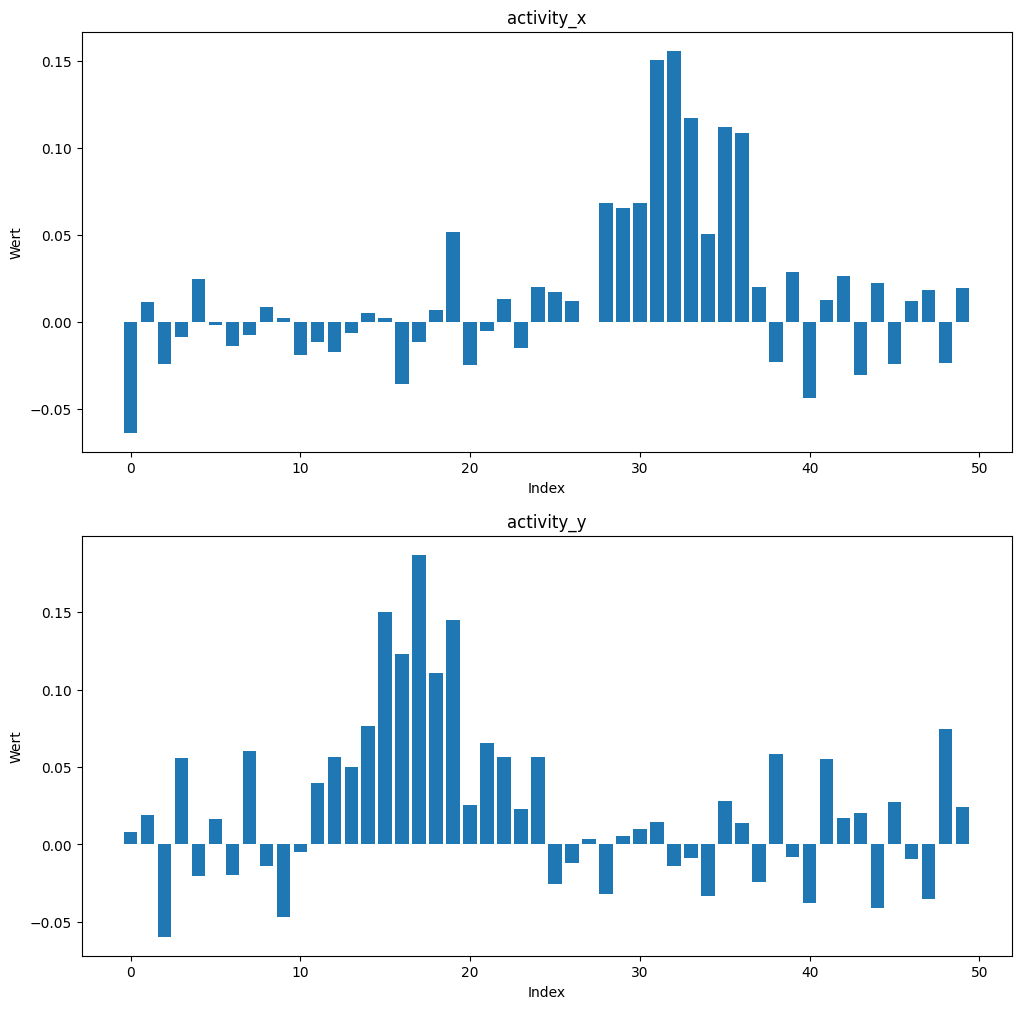

In [21]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.bar(range(N_NEURONS), s.data[p_activity_x][-1])
plt.title('activity_x')
plt.xlabel('Index')
plt.ylabel('Wert')

plt.subplot(2, 1, 2)
plt.bar(range(N_NEURONS), s.data[p_activity_y][-1])
plt.title('activity_y')
plt.xlabel('Index')
plt.ylabel('Wert')

### Visualisierung winput-Vektoren

Text(0, 0.5, 'Wert')

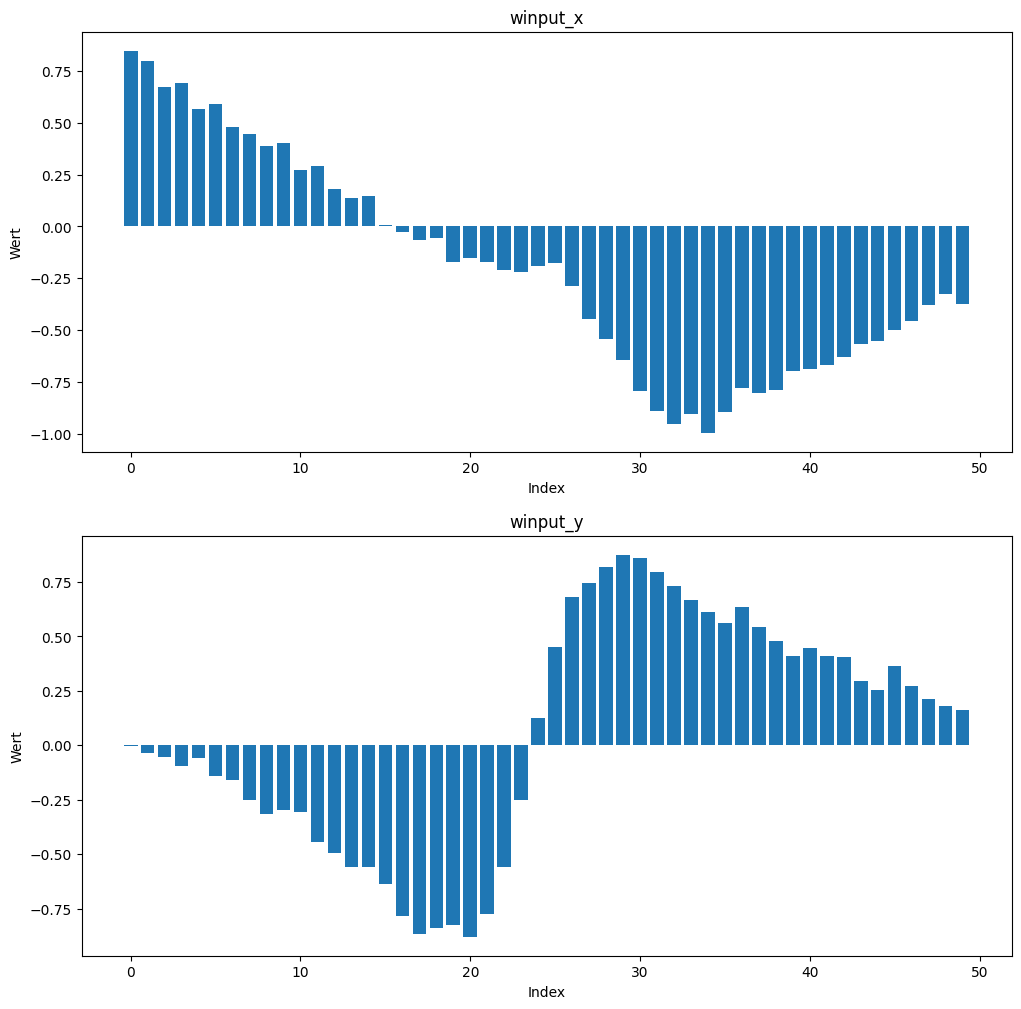

In [22]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.bar(range(N_NEURONS), s.data[p_winput_x][-1])
plt.title('winput_x')
plt.xlabel('Index')
plt.ylabel('Wert')

plt.subplot(2, 1, 2)
plt.bar(range(N_NEURONS), s.data[p_winput_y][-1])
plt.title('winput_y')
plt.xlabel('Index')
plt.ylabel('Wert')

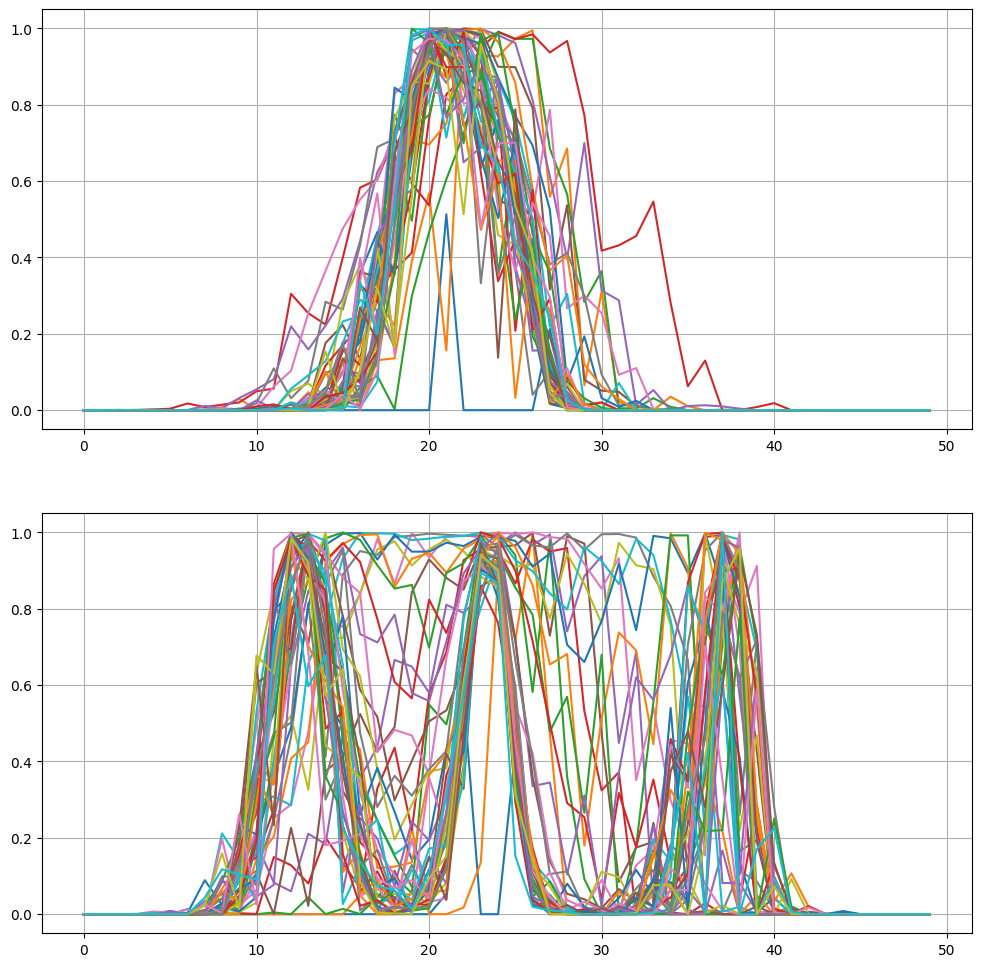

In [23]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.grid()
x = np.linspace(-RADIUS, RADIUS, N_NEURONS)
for i in range(N_NEURONS):
    # extract the preferred values (wight vector) of each neuron
    v_pref = s.data[p_winput_x][i]
    fx = np.exp(-(x - v_pref)**2 / (2 * s.data[p_std_x][i]**2))
    plt.plot([x for x in range(N_NEURONS)], fx)
    
plt.subplot(2, 1, 2)
plt.grid()
x = np.linspace(-RADIUS, RADIUS, N_NEURONS)
for i in range(N_NEURONS):
    # extract the preferred values (wight vector) of each neuron
    v_pref = s.data[p_winput_y][i]
    fx = np.exp(-(x - v_pref)**2 / (2 * s.data[p_std_y][i]**2))
    plt.plot([x for x in range(N_NEURONS)], fx)

### Visualisierung std-Vektoren

Text(0, 0.5, 'Wert')

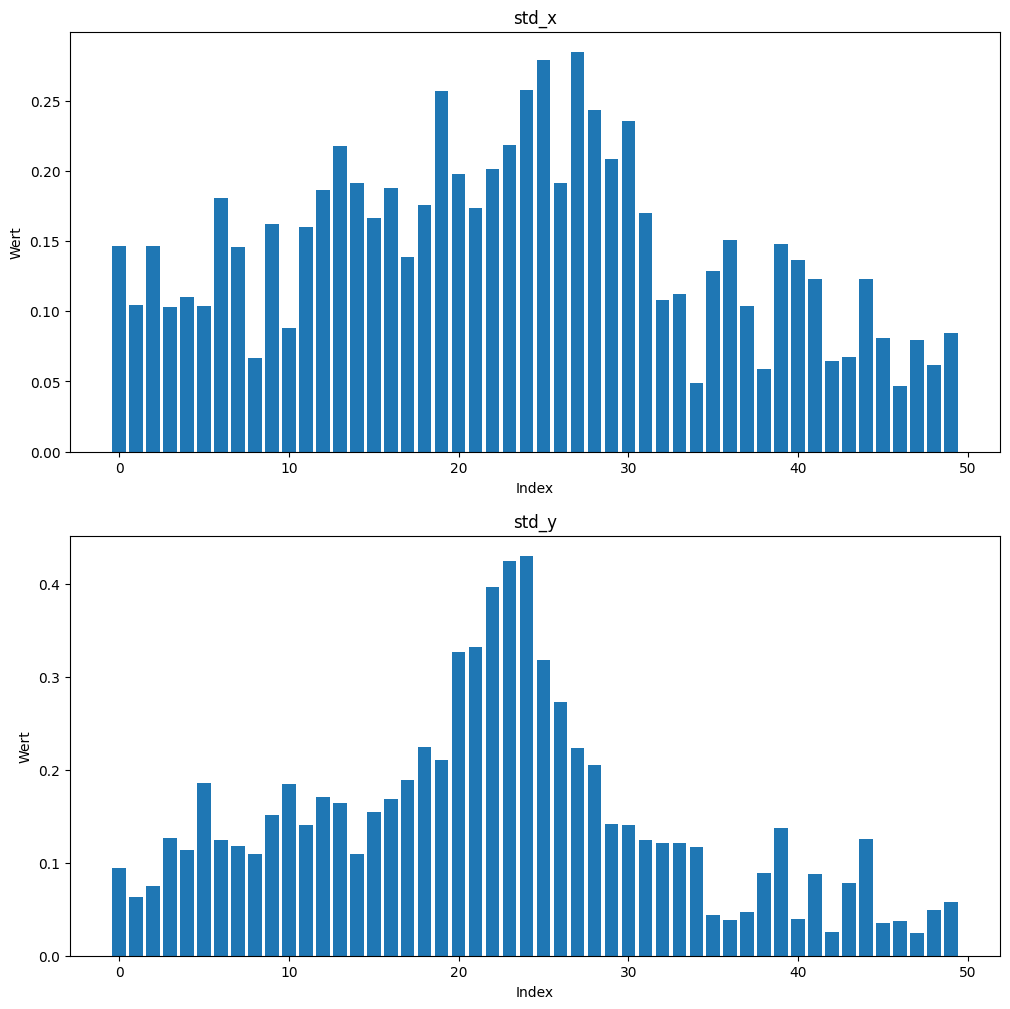

In [24]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.bar(range(N_NEURONS), s.data[p_std_x][-1])
plt.title('std_x')
plt.xlabel('Index')
plt.ylabel('Wert')

plt.subplot(2, 1, 2)
plt.bar(range(N_NEURONS), s.data[p_std_y][-1])
plt.title('std_y')
plt.xlabel('Index')
plt.ylabel('Wert')

### Visualisierung xmod-Matrizen

Text(0, 0.5, 'Zeilenindex')

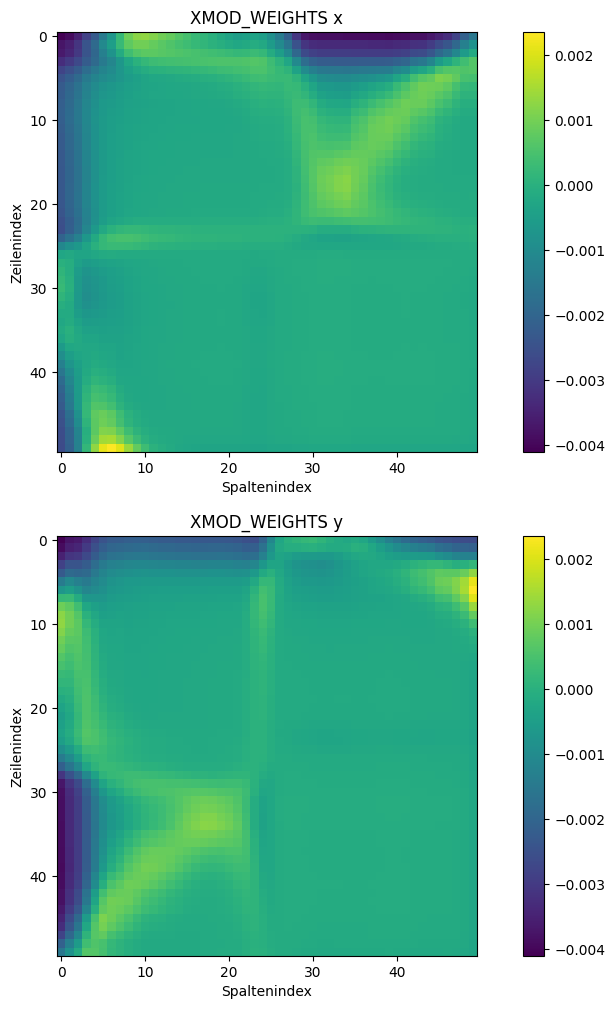

In [25]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.imshow(XMOD_WEIGHTS[0], cmap='viridis')
plt.colorbar() 
plt.title('XMOD_WEIGHTS x') 
plt.xlabel('Spaltenindex')
plt.ylabel('Zeilenindex')

plt.subplot(2, 1, 2)
plt.imshow(XMOD_WEIGHTS[1], cmap='viridis')
plt.colorbar() 
plt.title('XMOD_WEIGHTS y') 
plt.xlabel('Spaltenindex')
plt.ylabel('Zeilenindex')

# Ansatz 2: Nengo-Implementierung nur des Aktivitäts-Vektor als Ensemble

## nur Inner-Learning

In [ ]:
reset_matrices()

In [ ]:
with nengo.Network() as model_inner:
    #Ensembles auf denen das innere Lernen durchgeführt wird
    #Repräsentieren dabei den Aktivitätsvektor eines SOM
    x_inner = nengo.networks.EnsembleArray(N_NEURONS*30, n_ensembles=N_NEURONS, radius=RADIUS)
    y_inner = nengo.networks.EnsembleArray(N_NEURONS*30, n_ensembles=N_NEURONS, radius=RADIUS)

    #Methode, welche inners Lernen durchführt
    def inner_learn(t, x):
        # Berechnen der aktuellen Epoche (vergangene Zeit / Schrittweite)
        epoch = int(t/DT)

        if epoch == 1: #wenn erster Durchlauf, Werte der Neuronen initialisieren
            activities = np.zeros((N_ENS, N_NEURONS))
        else:
            activities = np.array([x[:N_NEURONS], x[N_NEURONS:]])

        #Inneres Lernen
        if epoch <= MAX_EPOCHS_IN_LEARNING:
            activities = inner_learning(activities, epoch)
        
        return activities.flatten()

    inner_learn_node = nengo.Node(inner_learn, size_in=N_NEURONS*N_ENS, size_out=N_NEURONS*N_ENS)

    #Verbindungen von Neuronen der Ensembles zu inneren Lernmethode ...
    nengo.Connection(x_inner.output, inner_learn_node[:N_NEURONS])
    nengo.Connection(y_inner.output, inner_learn_node[N_NEURONS:])
    # ... und wieder zurück
    nengo.Connection(inner_learn_node[:N_NEURONS], x_inner.input)
    nengo.Connection(inner_learn_node[N_NEURONS:], y_inner.input)

    #Sammeln der Proben
    x_inner_probe = nengo.Probe(x_inner)
    y_inner_probe = nengo.Probe(y_inner)

In [ ]:
with nengo.Simulator(model_inner, dt=DT) as sim_inner:
    sim_inner.run_steps(MAX_EPOCHS_IN_LEARNING)

### Visualisierung Aktivitätsvektoren

In [ ]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.bar(range(N_NEURONS), sim_inner.data[x_inner_probe][-1])
plt.title('activity_x')
plt.xlabel('Index')
plt.ylabel('Wert')

plt.subplot(2, 1, 2)
plt.bar(range(N_NEURONS), sim_inner.data[y_inner_probe][-1])
plt.title('activity_y')
plt.xlabel('Index')
plt.ylabel('Wert')

### Visualisierung winput-Vektoren

In [ ]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.bar(range(N_NEURONS), INPUT_WEIGHTS[0])
plt.title('winput_x')
plt.xlabel('Index')
plt.ylabel('Wert')

plt.subplot(2, 1, 2)
plt.bar(range(N_NEURONS), INPUT_WEIGHTS[1])
plt.title('winput_y')
plt.xlabel('Index')
plt.ylabel('Wert')

In [ ]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.hist(INPUT_WEIGHTS[0],bins=50,facecolor="blue", edgecolor="black", alpha=0.7)

plt.subplot(2, 1, 2)
plt.hist(INPUT_WEIGHTS[1],bins=50,facecolor="blue", edgecolor="black", alpha=0.7)

### Visualisierung std-Vektoren

In [ ]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.bar(range(N_NEURONS), STD[0])
plt.title('std_x')
plt.xlabel('Index')
plt.ylabel('Wert')

plt.subplot(2, 1, 2)
plt.bar(range(N_NEURONS), STD[1])
plt.title('std_y')
plt.xlabel('Index')
plt.ylabel('Wert')

### Visualisierung Tuning-Curves

In [ ]:
pref = [1, 6, 13, 40, 45, 85, 90, 98]

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
v_pref = np.sort(INPUT_WEIGHTS[0],axis=0)
for idx in range(len(pref)):
    # extract the preferred values (wight vector) of each neuron
    idx_pref = pref[idx]
    fx = np.exp(-(x - v_pref[idx_pref])**2/(2*STD[0][idx_pref]**2))
    plt.plot([x for x in range(N_NEURONS)],fx)

plt.subplot(2, 1, 2)
v_pref = np.sort(INPUT_WEIGHTS[1],axis=0)
for idx in range(len(pref)):
    # extract the preferred values (wight vector) of each neuron
    idx_pref = pref[idx]
    fx = np.exp(-(x - v_pref[idx_pref])**2/(2*STD[1][idx_pref]**2))
    plt.plot([x for x in range(N_NEURONS)],fx)

In [ ]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.grid()
x = np.linspace(-RADIUS, RADIUS, N_NEURONS)
for i in range(N_NEURONS):
    # extract the preferred values (wight vector) of each neuron
    v_pref = INPUT_WEIGHTS[0][i]
    fx = np.exp(-(x - v_pref)**2 / (2 * STD[0][i]**2))
    plt.plot([x for x in range(N_NEURONS)], fx)
    
plt.subplot(2, 1, 2)
plt.grid()
x = np.linspace(-RADIUS, RADIUS, N_NEURONS)
for i in range(N_NEURONS):
    # extract the preferred values (wight vector) of each neuron
    v_pref = INPUT_WEIGHTS[1][i]
    fx = np.exp(-(x - v_pref)**2 / (2 * STD[1][i]**2))
    plt.plot([x for x in range(N_NEURONS)], fx)

### Visualisierung der xmod-Matrizen

In [ ]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.imshow(XMOD_WEIGHTS[0], cmap='viridis')
plt.colorbar() 
plt.title('XMOD_WEIGHTS x') 
plt.xlabel('Spaltenindex')
plt.ylabel('Zeilenindex')

plt.subplot(2, 1, 2)
plt.imshow(XMOD_WEIGHTS[1], cmap='viridis')
plt.colorbar() 
plt.title('XMOD_WEIGHTS y') 
plt.xlabel('Spaltenindex')
plt.ylabel('Zeilenindex')

## nur XMod-Learning

In [ ]:
with nengo.Network() as model_xmod:
    #Ensembles auf denen das innere Lernen durchgeführt wird
    #Repräsentieren dabei den Aktivitätsvektor eines SOM
    x_xmod = nengo.networks.EnsembleArray(N_NEURONS*30, n_ensembles=N_NEURONS, radius=RADIUS)
    y_xmod = nengo.networks.EnsembleArray(N_NEURONS*30, n_ensembles=N_NEURONS, radius=RADIUS)

    #Methode, welche XMOD-Lernen durchführt
    def xmod_learn(t,x):
        activities = np.array([x[:N_NEURONS], x[N_NEURONS:]])

        #XMOD-Lernen
        activities =\
        covariance_learning(activities, int(t/DT))
        #oja_learning(activities)
        #hebbian_learning(activities)

        return activities.flatten()

    xmod_learn_node = nengo.Node(xmod_learn, size_in=N_NEURONS*N_ENS, size_out=N_NEURONS*N_ENS)

    #Verbindungen von Neuronen der Ensembles zu xmod Lernmethode ...
    nengo.Connection(x_xmod.output, xmod_learn_node[:N_NEURONS])
    nengo.Connection(y_xmod.output, xmod_learn_node[N_NEURONS:])
    # ... und wieder zurück
    nengo.Connection(xmod_learn_node[:N_NEURONS], x_xmod.input)
    nengo.Connection(xmod_learn_node[N_NEURONS:], y_xmod.input)

    #Sammeln der Proben
    x_xmod_probe = nengo.Probe(x_xmod)
    y_xmod_probe = nengo.Probe(y_xmod)

In [ ]:
with nengo.Simulator(model_xmod, dt=DT) as sim_xmod:
    sim_xmod.run_steps(MAX_EPOCHS_XMOD_LEARNING)

### Visualisierung Aktivitätsvektoren

In [ ]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.bar(range(N_NEURONS), sim_xmod.data[x_xmod_probe][-1])
plt.title('activity_x')
plt.xlabel('Index')
plt.ylabel('Wert')

plt.subplot(2, 1, 2)
plt.bar(range(N_NEURONS), sim_xmod.data[y_xmod_probe][-1])
plt.title('activity_y')
plt.xlabel('Index')
plt.ylabel('Wert')

### Visualisierung winput-Vektoren

In [ ]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.bar(range(N_NEURONS), INPUT_WEIGHTS[0])
plt.title('winput_x')
plt.xlabel('Index')
plt.ylabel('Wert')

plt.subplot(2, 1, 2)
plt.bar(range(N_NEURONS), INPUT_WEIGHTS[1])
plt.title('winput_y')
plt.xlabel('Index')
plt.ylabel('Wert')

In [ ]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.hist(INPUT_WEIGHTS[0],bins=50,facecolor="blue", edgecolor="black", alpha=0.7)

plt.subplot(2, 1, 2)
plt.hist(INPUT_WEIGHTS[1],bins=50,facecolor="blue", edgecolor="black", alpha=0.7)

### Visualisierung std-Vektoren

In [ ]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.bar(range(N_NEURONS), STD[0])
plt.title('std_x')
plt.xlabel('Index')
plt.ylabel('Wert')

plt.subplot(2, 1, 2)
plt.bar(range(N_NEURONS), STD[1])
plt.title('std_y')
plt.xlabel('Index')
plt.ylabel('Wert')

### Visualisierung Tuning-Curves

In [ ]:
pref = [1, 6, 13, 40, 45, 85, 90, 98]

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
v_pref = np.sort(INPUT_WEIGHTS[0],axis=0)
for idx in range(len(pref)):
    # extract the preferred values (wight vector) of each neuron
    idx_pref = pref[idx]
    fx = np.exp(-(x - v_pref[idx_pref])**2/(2*STD[0][idx_pref]**2))
    plt.plot([x for x in range(N_NEURONS)],fx)

plt.subplot(2, 1, 2)
v_pref = np.sort(INPUT_WEIGHTS[1],axis=0)
for idx in range(len(pref)):
    # extract the preferred values (wight vector) of each neuron
    idx_pref = pref[idx]
    fx = np.exp(-(x - v_pref[idx_pref])**2/(2*STD[1][idx_pref]**2))
    plt.plot([x for x in range(N_NEURONS)],fx)

In [ ]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.grid()
x = np.linspace(-RADIUS, RADIUS, N_NEURONS)
for i in range(N_NEURONS):
    # extract the preferred values (wight vector) of each neuron
    v_pref = INPUT_WEIGHTS[0][i]
    fx = np.exp(-(x - v_pref)**2 / (2 * STD[0][i]**2))
    plt.plot([x for x in range(N_NEURONS)], fx)
    
plt.subplot(2, 1, 2)
plt.grid()
x = np.linspace(-RADIUS, RADIUS, N_NEURONS)
for i in range(N_NEURONS):
    # extract the preferred values (wight vector) of each neuron
    v_pref = INPUT_WEIGHTS[1][i]
    fx = np.exp(-(x - v_pref)**2 / (2 * STD[1][i]**2))
    plt.plot([x for x in range(N_NEURONS)], fx)

### Visualisierung xmod_weights-Matrizen

In [ ]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.imshow(XMOD_WEIGHTS[0], cmap='viridis')
plt.colorbar() 
plt.title('XMOD_WEIGHTS x') 
plt.xlabel('Spaltenindex')
plt.ylabel('Zeilenindex')

plt.subplot(2, 1, 2)
plt.imshow(XMOD_WEIGHTS[1], cmap='viridis')
plt.colorbar() 
plt.title('XMOD_WEIGHTS y') 
plt.xlabel('Spaltenindex')
plt.ylabel('Zeilenindex')

## vollständige Implementierung

In [89]:
reset_matrices()

In [91]:
with nengo.Network() as model:
    #Ensembles auf denen das innere Lernen durchgeführt wird
    #Repräsentieren dabei den Aktivitätsvektor eines SOM
    x = nengo.networks.EnsembleArray(N_NEURONS*30, n_ensembles=N_NEURONS, radius=RADIUS)
    y = nengo.networks.EnsembleArray(N_NEURONS*30, n_ensembles=N_NEURONS, radius=RADIUS)

    #Methode, welche inners Lernen durchführt
    def inner_learn(t, x):
        # Berechnen der aktuellen Epoche (vergangene Zeit / Schrittweite)
        epoch = int(t/DT)

        if epoch == 1: #wenn erster Durchlauf, Werte der Neuronen initialisieren
            activities = np.zeros((N_ENS, N_NEURONS))
        else:
            activities = np.array([x[:N_NEURONS], x[N_NEURONS:]])

        #Inneres Lernen
        if epoch <= MAX_EPOCHS_IN_LEARNING:
            activities = inner_learning(activities, epoch)
        
        return activities.flatten()

    #Methode, welche XMOD-Lernen durchführt
    def xmod_learn(t,x):
        activities = np.array([x[:N_NEURONS], x[N_NEURONS:]])

        #XMOD-Lernen
        activities =\
        covariance_learning(activities, int(t/DT))
        #oja_learning(activities)
        #hebbian_learning(activities)

        return activities.flatten()

    inner_learn_node = nengo.Node(inner_learn, size_in=N_NEURONS*N_ENS, size_out=N_NEURONS*N_ENS)
    xmod_learn_node = nengo.Node(xmod_learn, size_in=N_NEURONS*N_ENS, size_out=N_NEURONS*N_ENS)

    #Verbindungen von Neuronen der Ensembles zu inneren Lernmethode ...
    nengo.Connection(x.output, inner_learn_node[:N_NEURONS])
    nengo.Connection(y.output, inner_learn_node[N_NEURONS:])
    # ... dann zur XMod-Lernmethode ...
    nengo.Connection(inner_learn_node, xmod_learn_node)
    # ... und wieder zurück
    nengo.Connection(xmod_learn_node[:N_NEURONS], x.input)
    nengo.Connection(xmod_learn_node[N_NEURONS:], y.input)

    #Sammeln der Proben
    x_probe = nengo.Probe(x.output)
    y_probe = nengo.Probe(y.output)

In [92]:
with nengo.Simulator(model, dt=DT) as sim:
    sim.run_steps(MAX_EPOCHS_XMOD_LEARNING)

Build finished in 0:00:47.                                                      
Simulation finished in 0:00:36.                                                 


### Visualisierung Aktivitätsvektoren

Text(0, 0.5, 'Wert')

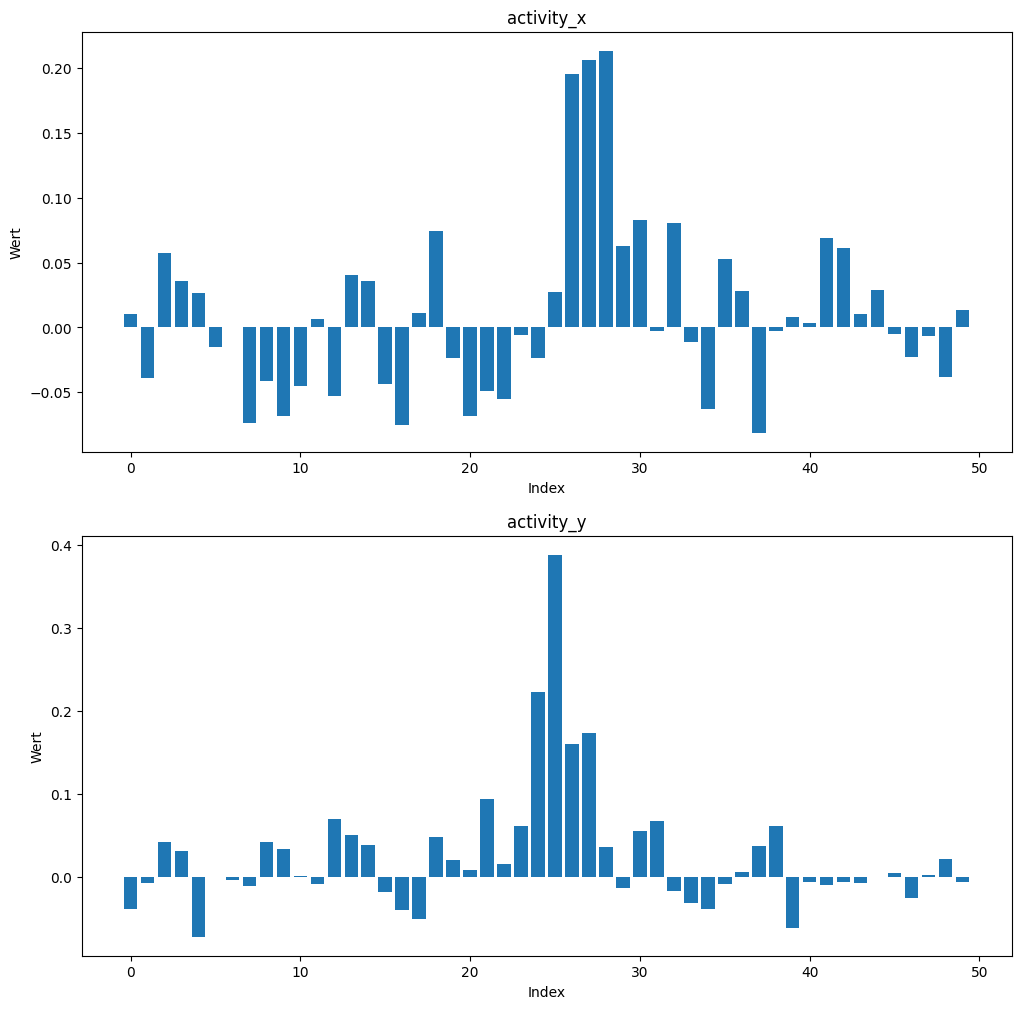

In [93]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.bar(range(N_NEURONS), sim.data[x_probe][-1])
plt.title('activity_x')
plt.xlabel('Index')
plt.ylabel('Wert')

plt.subplot(2, 1, 2)
plt.bar(range(N_NEURONS), sim.data[y_probe][-1])
plt.title('activity_y')
plt.xlabel('Index')
plt.ylabel('Wert')

### Visualisierung winput-Vektoren

Text(0, 0.5, 'Wert')

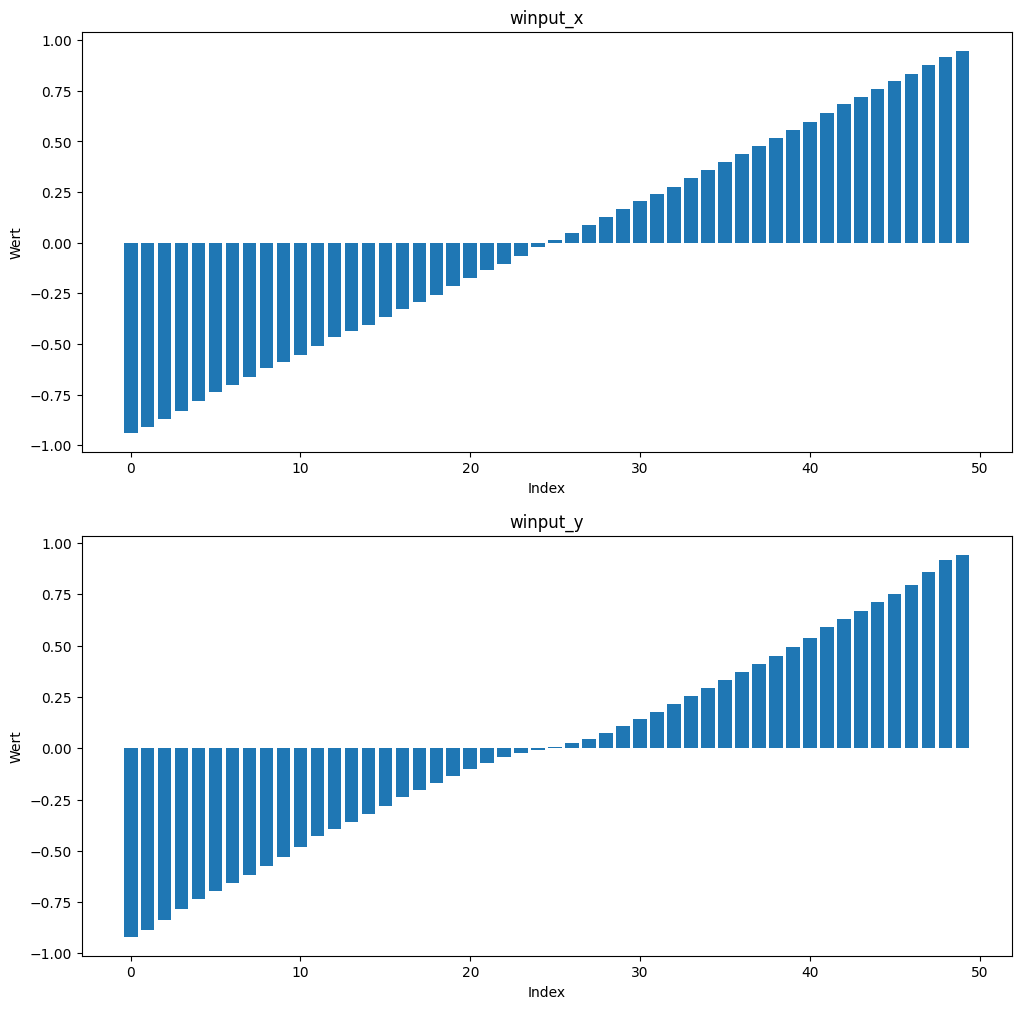

In [94]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.bar(range(N_NEURONS), INPUT_WEIGHTS[0])
plt.title('winput_x')
plt.xlabel('Index')
plt.ylabel('Wert')

plt.subplot(2, 1, 2)
plt.bar(range(N_NEURONS), INPUT_WEIGHTS[1])
plt.title('winput_y')
plt.xlabel('Index')
plt.ylabel('Wert')

(array([2., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 2., 1., 2., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 2.]),
 array([-0.91835742, -0.88113853, -0.84391964, -0.80670075, -0.76948186,
        -0.73226297, -0.69504408, -0.65782518, -0.62060629, -0.5833874 ,
        -0.54616851, -0.50894962, -0.47173073, -0.43451184, -0.39729295,
        -0.36007406, -0.32285517, -0.28563628, -0.24841739, -0.2111985 ,
        -0.17397961, -0.13676071, -0.09954182, -0.06232293, -0.02510404,
         0.01211485,  0.04933374,  0.08655263,  0.12377152,  0.16099041,
         0.1982093 ,  0.23542819,  0.27264708,  0.30986597,  0.34708487,
         0.38430376,  0.42152265,  0.45874154,  0.49596043,  0.53317932,
         0.57039821,  0.6076171 ,  0.64483599,  0.68205488,  0.71927377,
         0.75649266,  0.79371155,  0.83093044,  0.86814934,  0.90536823,
         0.94258712]),
 <BarContainer object

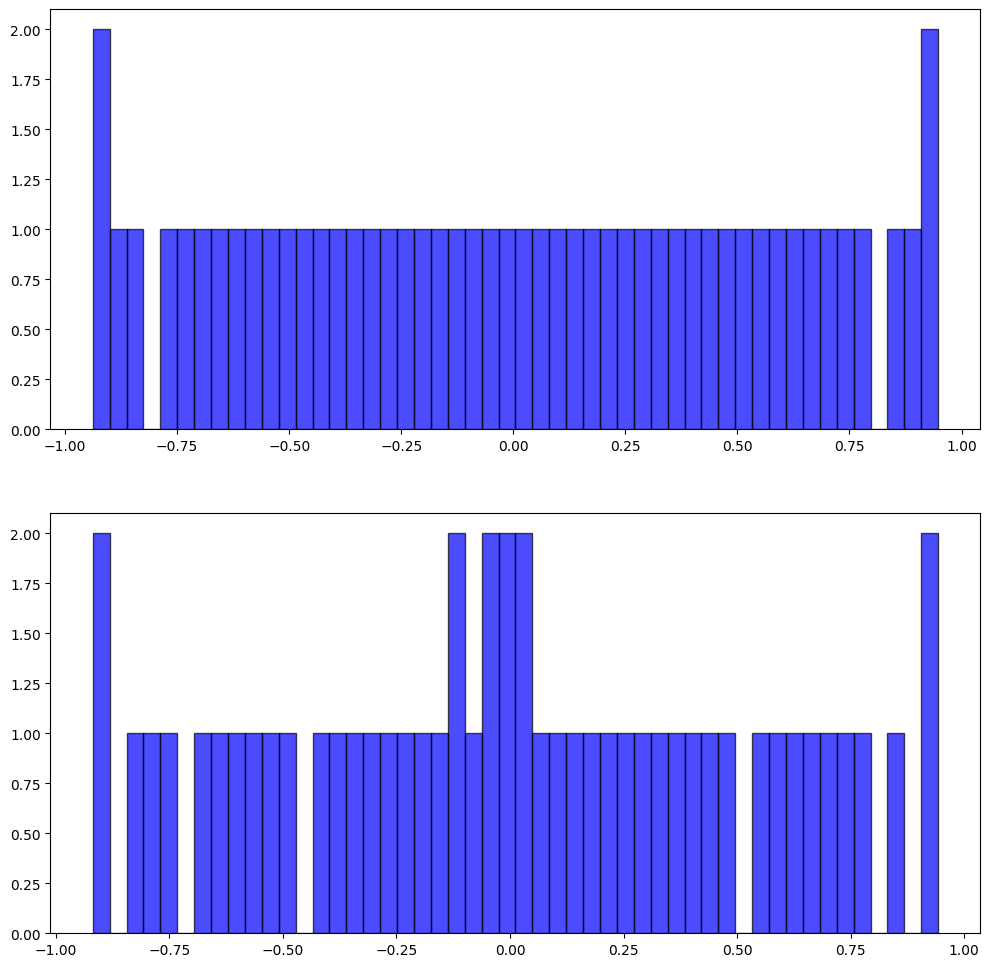

In [95]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.hist(INPUT_WEIGHTS[0],bins=50,facecolor="blue", edgecolor="black", alpha=0.7)

plt.subplot(2, 1, 2)
plt.hist(INPUT_WEIGHTS[1],bins=50,facecolor="blue", edgecolor="black", alpha=0.7)

### Visualisierung std-Vektoren

Text(0, 0.5, 'Wert')

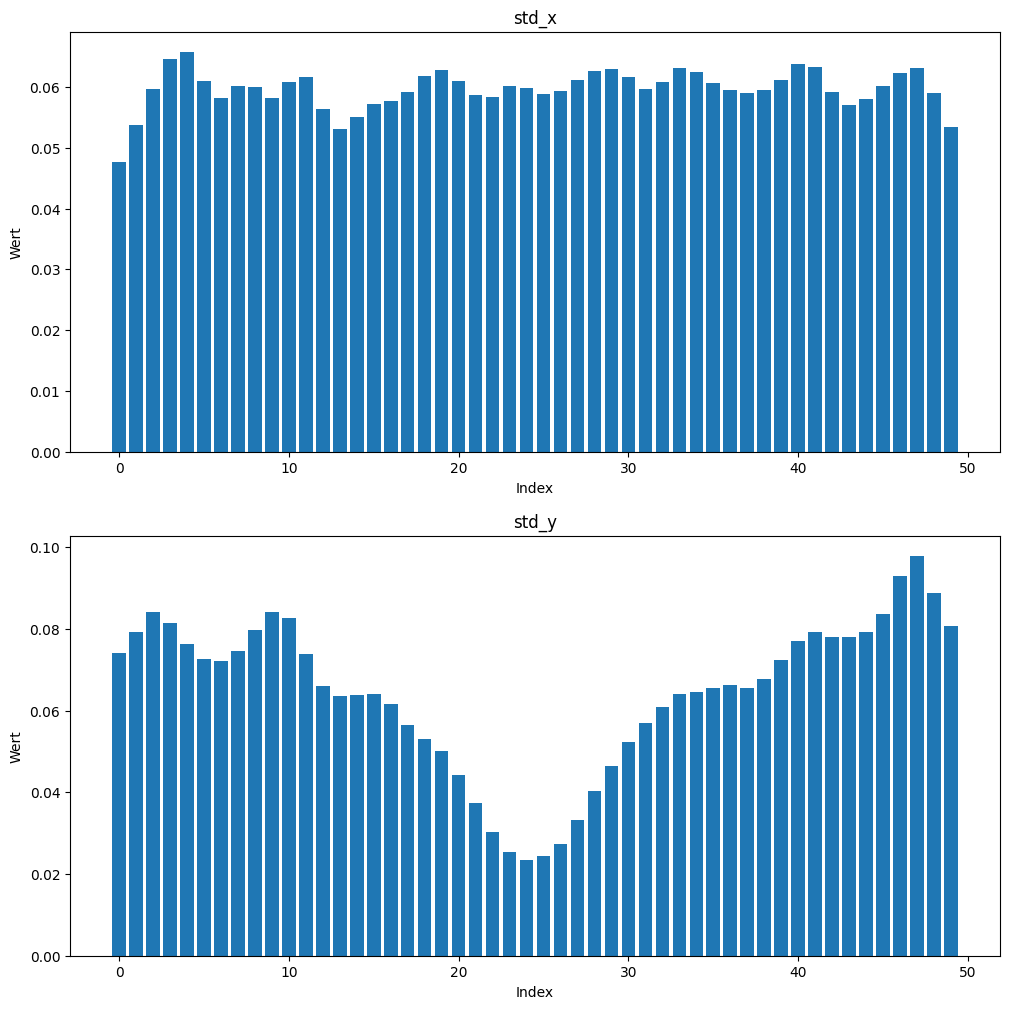

In [96]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.bar(range(N_NEURONS), STD[0])
plt.title('std_x')
plt.xlabel('Index')
plt.ylabel('Wert')

plt.subplot(2, 1, 2)
plt.bar(range(N_NEURONS), STD[1])
plt.title('std_y')
plt.xlabel('Index')
plt.ylabel('Wert')

### Visualisierung Tuning-Curves

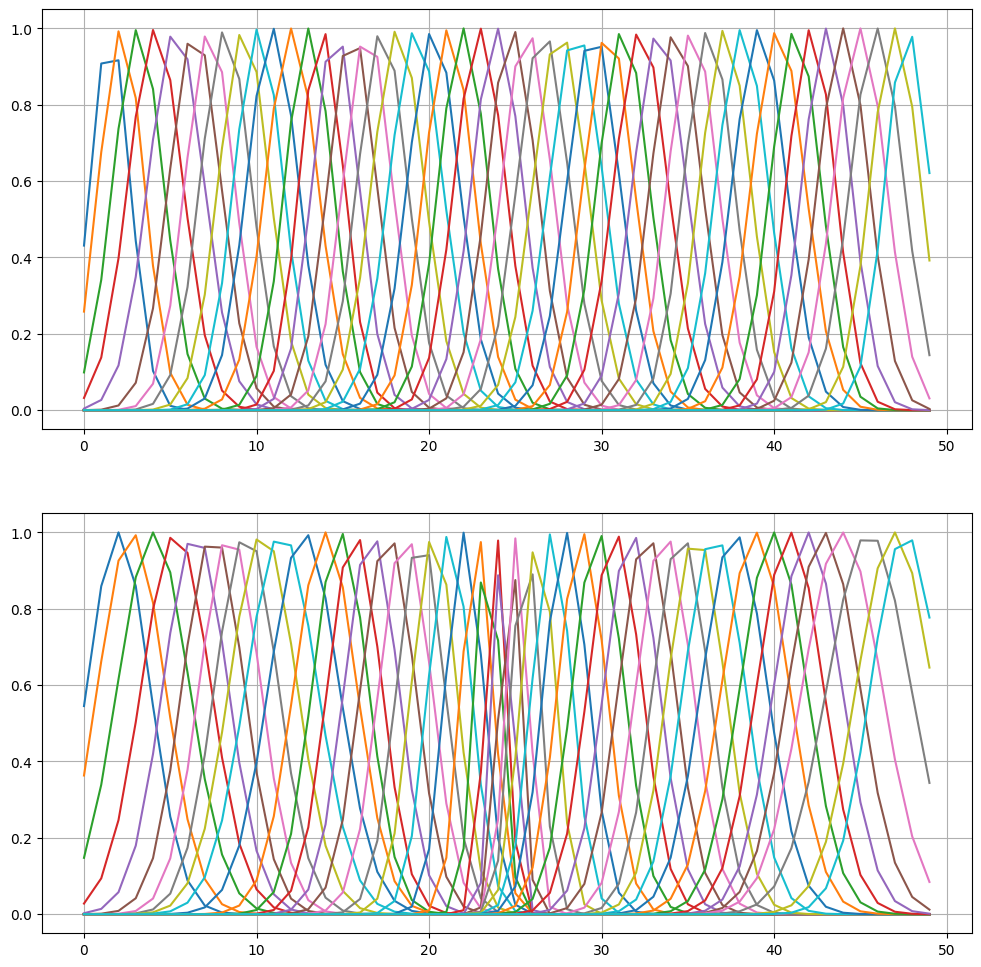

In [97]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.grid()
x = np.linspace(-RADIUS, RADIUS, N_NEURONS)
for i in range(N_NEURONS):
    # extract the preferred values (wight vector) of each neuron
    v_pref = INPUT_WEIGHTS[0][i]
    fx = np.exp(-(x - v_pref)**2 / (2 * STD[0][i]**2))
    plt.plot([x for x in range(N_NEURONS)], fx)
    
plt.subplot(2, 1, 2)
plt.grid()
x = np.linspace(-RADIUS, RADIUS, N_NEURONS)
for i in range(N_NEURONS):
    # extract the preferred values (wight vector) of each neuron
    v_pref = INPUT_WEIGHTS[1][i]
    fx = np.exp(-(x - v_pref)**2 / (2 * STD[1][i]**2))
    plt.plot([x for x in range(N_NEURONS)], fx)

IndexError: index 85 is out of bounds for axis 0 with size 50

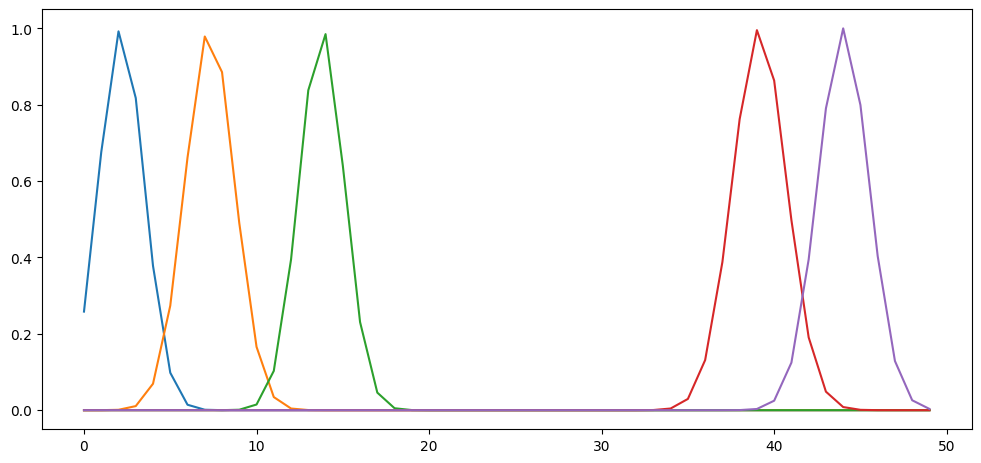

In [99]:
pref = [1, 6, 13, 40, 45, 85, 90, 98]

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
v_pref = np.sort(INPUT_WEIGHTS[0],axis=0)
for i in range(len(pref)):
    # extract the preferred values (wight vector) of each neuron
    i_pref = pref[i]
    fx = np.exp(-(x - v_pref[i_pref])**2 / (2 * STD[0][i_pref]**2))
    plt.plot([x for x in range(N_NEURONS)],fx)

plt.subplot(2, 1, 2)
v_pref = np.sort(INPUT_WEIGHTS[1],axis=0)
for idx in range(len(pref)):
    # extract the preferred values (wight vector) of each neuron
    idx_pref = pref[idx]
    fx = np.exp(-(x - v_pref[i_pref])**2 / (2 * STD[1][i_pref]**2))
    plt.plot([x for x in range(N_NEURONS)],fx)

### Visualisierung xmod-Matrizen

Text(0, 0.5, 'Zeilenindex')

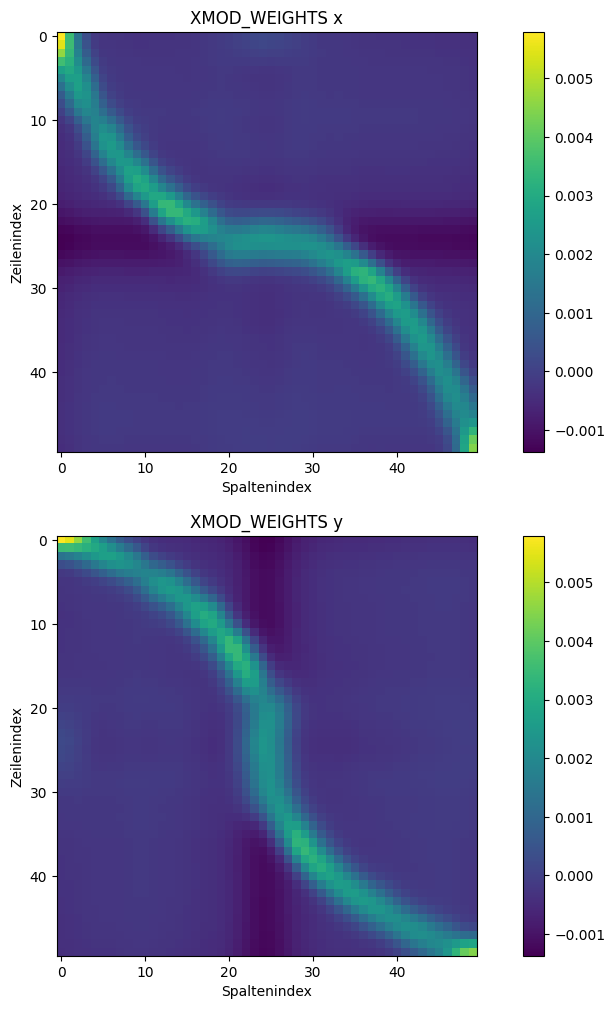

In [100]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.imshow(XMOD_WEIGHTS[0], cmap='viridis')
plt.colorbar() 
plt.title('XMOD_WEIGHTS x') 
plt.xlabel('Spaltenindex')
plt.ylabel('Zeilenindex')

plt.subplot(2, 1, 2)
plt.imshow(XMOD_WEIGHTS[1], cmap='viridis')
plt.colorbar() 
plt.title('XMOD_WEIGHTS y') 
plt.xlabel('Spaltenindex')
plt.ylabel('Zeilenindex')